# Hand Gesture Recognition

## American Sign Language

### Importing Libraries

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from keras.callbacks import ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

### Loading Data

In [26]:
data_train = pd.read_csv("./dataset/sign_mnist_train.csv")
data_test = pd.read_csv("./dataset/sign_mnist_test.csv")

In [27]:
data_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [28]:
def show_image(img_label, dataframe):
    
    label = dataframe['label'][img_label]
    pixels = dataframe.iloc[img_label, 1:]
    # turn into unsigned 8 bits
    pixels = np.array(pixels, dtype='uint8')
    # convert to 2d array
    pixels = pixels.reshape((28, 28))
    
    plt.title(f"Label is {label}")
    plt.imshow(pixels, cmap='gray')
    plt.show();

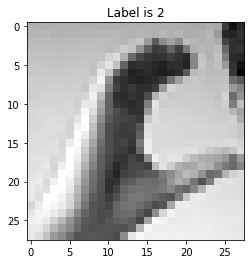

In [29]:
show_image(20, data_test)

### Data Preprocessing

In [30]:
# extracting labels

y_train = data_train['label']
y_test = data_test['label']

# remove the labels
del data_train['label']
del data_test['label']

In [31]:
# Label Binarizer
# Convert categorical values to 1s and 0s

label_binarizer = LabelBinarizer()

y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.fit_transform(y_test)

In [32]:
x_train = data_train.values
x_test = data_test.values

In [33]:
# normalizing pixels to between 0 and 1

x_train = x_train/255
x_test = x_test/255

In [34]:
# reshaping

x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

### Data  Augmentation

In [35]:
# Augmentation to improves model to reduce overfitting

data_generator = ImageDataGenerator(
                    # if True, input mean will be 0
                    featurewise_center = False,
                    # if True, sample mean will be 0
                    samplewise_center = False,
                    # If True, input will be standard of the data set 
                    featurewise_std_normalization = False,
                    samplewise_std_normalization = False,
                    # Reduces redundancy of matrix of pixel images (when background is not clear)
                    zca_whitening = False,
                    # Rotates imageat random to set value 
                    rotation_range = 10,
                    # Zoom into image at random
                    zoom_range = 0.1,
                    # Shift image horizontally at random depedning on the range
                    width_shift_range = 0.1,
                    # Shift image vertically at random depedning on the range
                    height_shift_range = 0.1,
                    # Flips images horizontally at random
                    horizontal_flip = False,
                    # Flips images vertically at random
                    vertical_flip = False
                )


data_generator.fit(x_train)

### Creating the Model

In [37]:
model = Sequential()

model.add(
    Conv2D(
        filters = 75, kernel_size = (3,3),
        strides = 1, padding = 'same',
        activation = 'relu',
        #input shape only for first layer
        input_shape = (28, 28, 1)
    )
)


model.add(
    # Helps to process data faster and stable by re-centering data 
    BatchNormalization()
)

model.add(
    MaxPool2D(
        pool_size = (2,2), strides = 2,
        padding = 'same'
    )
)

model.add(
    Conv2D(
        filters = 50, kernel_size = (3,3),
        strides = 1, padding = 'same',
        activation = 'relu',
        input_shape = (28, 28, 1)
    )
)

model.add(
    # Randomly drop 20% to prevent overfitting
    Dropout(0.2)
)


model.add(
    # Helps to process data faster and stable by re-centering data 
    BatchNormalization()
)

model.add(
    MaxPool2D(
        pool_size = (2,2), strides = 2,
        padding = 'same'
    )
)


model.add(
    Conv2D(
        filters = 25, kernel_size = (3,3),
        strides = 1, padding = 'same',
        activation = 'relu',
        input_shape = (28, 28, 1)
    )
)


model.add(
    # Helps to process data faster and stable by re-centering data 
    BatchNormalization()
)


model.add(
    MaxPool2D(
        pool_size = (2,2), strides = 2,
        padding = 'same'
    )
)


model.add(
    # This layer reshapes tensor so shape is equal to number of elements in tensor
    Flatten()
)

model.add(
    # Fully connected layer
    Dense(
        units = 512, activation = 'relu'
    )
)

model.add(
    # Randomly drop 30% to prevent overfitting
    Dropout(0.3)
)


model.add(
    # Fully connected layer
    Dense(
        units = 24, activation = 'softmax'
    )
)

In [42]:
model.compile(
    optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy']
)

In [43]:
# Reduces learning rate when metric has stops improving

learning_rate_reduction = ReduceLROnPlateau(
                            monitor = 'val_accuracy', patience = 2,
                            verbose = 1, factor = 0.5,
                            min_lr = 0.00001
                          )

### Training the Model

In [44]:
model.fit(
    data_generator.flow(x_train, y_train, batch_size = 128),
    epochs = 20, validation_data = (x_test, y_test),
    callbacks = [learning_rate_reduction]
)

Epoch 1/20
215/215 [==============================] - 80s 367ms/step - loss: 0.2917 - accuracy: 0.8990 - val_loss: 1.7663 - val_accuracy: 0.4756
Epoch 2/20
215/215 [==============================] - 76s 355ms/step - loss: 0.1064 - accuracy: 0.9667 - val_loss: 1.1413 - val_accuracy: 0.6665
Epoch 3/20
215/215 [==============================] - 84s 390ms/step - loss: 0.0646 - accuracy: 0.9783 - val_loss: 0.0489 - val_accuracy: 0.9828
Epoch 4/20
215/215 [==============================] - 82s 382ms/step - loss: 0.0411 - accuracy: 0.9870 - val_loss: 0.0335 - val_accuracy: 0.9895
Epoch 5/20
215/215 [==============================] - 85s 395ms/step - loss: 0.0390 - accuracy: 0.9875 - val_loss: 0.0920 - val_accuracy: 0.9700
Epoch 6/20
215/215 [==============================] - 86s 398ms/step - loss: 0.0254 - accuracy: 0.9923 - val_loss: 0.0588 - val_accuracy: 0.9784

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7/20
215/215 [=============================

In [45]:
model.evaluate(x_test, y_test)

225/225 [==============================] - 4s 17ms/step - loss: 0.0023 - accuracy: 0.9990


[0.002317276317626238, 0.999023973941803]

### Model Predictions

In [49]:
predictions = model.predict_classes(x_test)

for i in range(len(predictions)):
    if(predictions[i] >= 9 or predictions[i] >=25):
        predictions[i] += 1
    
predictions[:5]

array([ 6,  5, 10,  0,  3], dtype=int64)

In [50]:
model.save('hand_gesture.h5')